In [ ]:
print("Advanced Computer Vision and Video Analytics_Lab5_Harish Sivakumar_E22CSEU0033")

Advanced Computer Vision and Video Analytics_Lab5_Harish Sivakumar_E22CSEU0033


<h3>Task 1</h3>

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import io

In [ ]:
input_image_path = "/content/NatureImg.png"
img = Image.open(input_image_path).convert('L')
img = np.array(img)

In [ ]:
pad_height = (8 - img.shape[0] % 8) % 8
pad_width = (8 - img.shape[1] % 8) % 8
padded_img = np.pad(img, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

In [ ]:
block_size = 8
height, width = padded_img.shape
blocks = [padded_img[i:i + block_size, j:j + block_size]
          for i in range(0, height, block_size)
          for j in range(0, width, block_size)]

In [ ]:
dct_blocks = [dct(dct(block.T, norm='ortho').T, norm='ortho') for block in blocks]

In [ ]:
quantization_matrix = np.ones((block_size, block_size)) * 10
quantized_blocks = [np.round(block / quantization_matrix) * quantization_matrix for block in dct_blocks]

In [ ]:
idct_blocks = [idct(idct(block.T, norm='ortho').T, norm='ortho') for block in quantized_blocks]

In [ ]:
reconstructed_img = np.zeros_like(padded_img)
block_idx = 0
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        reconstructed_img[i:i + block_size, j:j + block_size] = idct_blocks[block_idx]
        block_idx += 1

In [ ]:
reconstructed_img = reconstructed_img[:img.shape[0], :img.shape[1]]

In [ ]:
jpeg_output_image = Image.fromarray(np.uint8(reconstructed_img))
with io.BytesIO() as jpeg_buffer:
    jpeg_output_image.save(jpeg_buffer, format='JPEG', quality=30)
    jpeg_size = jpeg_buffer.tell()

In [ ]:
original_size = img.nbytes
jpeg_compression_rate = original_size / jpeg_size

In [ ]:
png_output_image = Image.fromarray(np.uint8(img))
with io.BytesIO() as png_buffer:
    png_output_image.save(png_buffer, format='PNG')
    png_size = png_buffer.tell()

In [ ]:
png_compression_rate = original_size / png_size

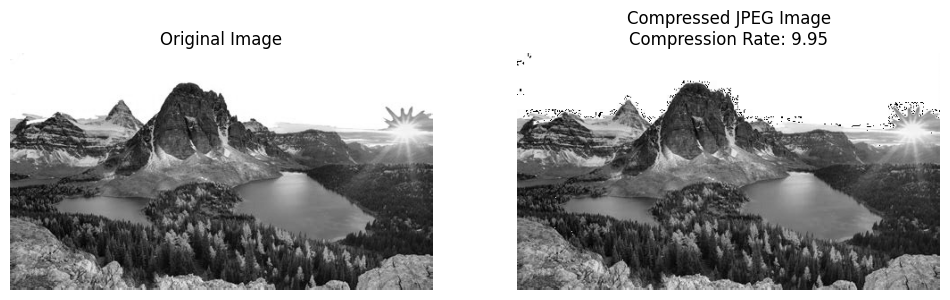

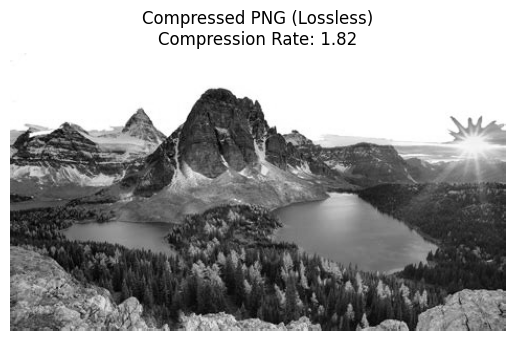

JPEG Compression Rate: 9.95
PNG Compression Rate: 1.82


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(reconstructed_img, cmap='gray')
axs[1].set_title(f"Compressed JPEG Image\nCompression Rate: {jpeg_compression_rate:.2f}")
axs[1].axis("off")
plt.show()

plt.imshow(img, cmap='gray')
plt.title(f"Compressed PNG (Lossless)\nCompression Rate: {png_compression_rate:.2f}")
plt.axis("off")
plt.show()

print(f"JPEG Compression Rate: {jpeg_compression_rate:.2f}")
print(f"PNG Compression Rate: {png_compression_rate:.2f}")

<h3>Task 2</h3>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [ ]:
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train_cat, y_val_cat, y_train, y_val = train_test_split(
    x_train, y_train_cat, y_train, test_size=0.2, random_state=42
)

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train_cat, epochs=10, validation_data=(x_val, y_val_cat))

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9005 - loss: 0.3210 - val_accuracy: 0.9820 - val_loss: 0.0584
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9848 - loss: 0.0472 - val_accuracy: 0.9873 - val_loss: 0.0389
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9905 - loss: 0.0303 - val_accuracy: 0.9887 - val_loss: 0.0363
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9938 - loss: 0.0194 - val_accuracy: 0.9905 - val_loss: 0.0358
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9960 - loss: 0.0130 - val_accuracy: 0.9859 - val_loss: 0.0504
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9961 - loss: 0.0123 - val_accuracy: 0.9872 - val_loss: 0.0483
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9970 - loss: 0.0086 - val_accuracy: 0.9894 - val_loss: 0.0447
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9976 - loss: 0.00

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat)
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9877 - loss: 0.0593
Test Accuracy: 0.9900


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9877 - loss: 0.0593
Test Loss: 0.0472
Test Accuracy: 0.9900


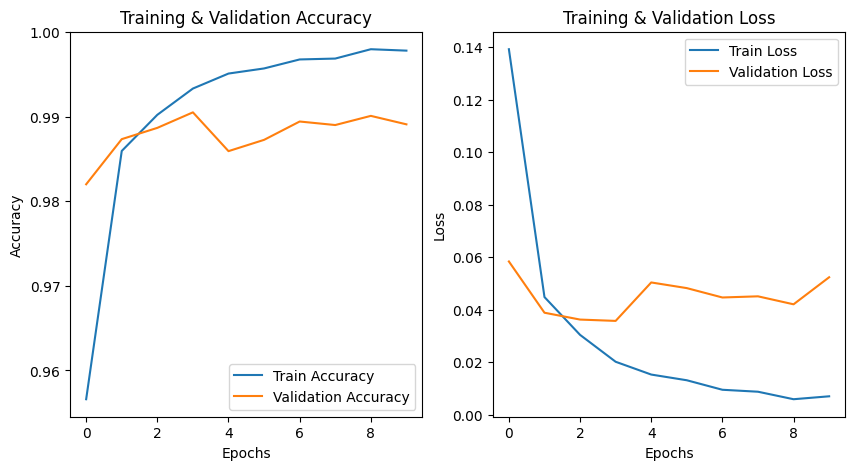

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

In [ ]:
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-Score: {report['weighted avg']['f1-score']:.4f}")

Precision: 0.9900
Recall: 0.9900
F1-Score: 0.9900


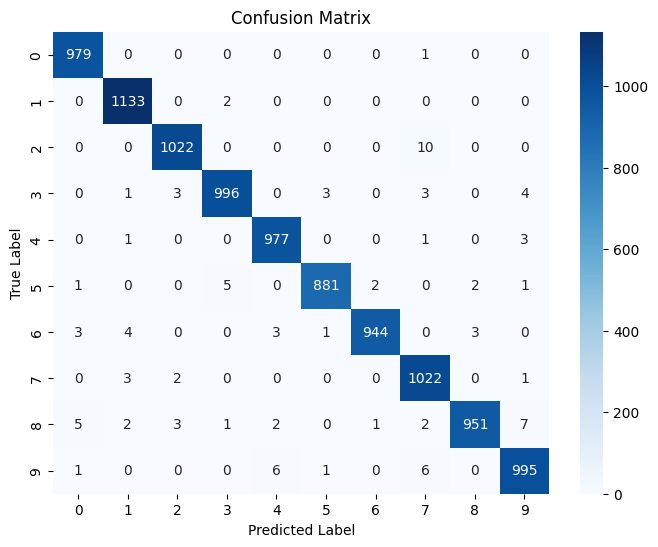

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

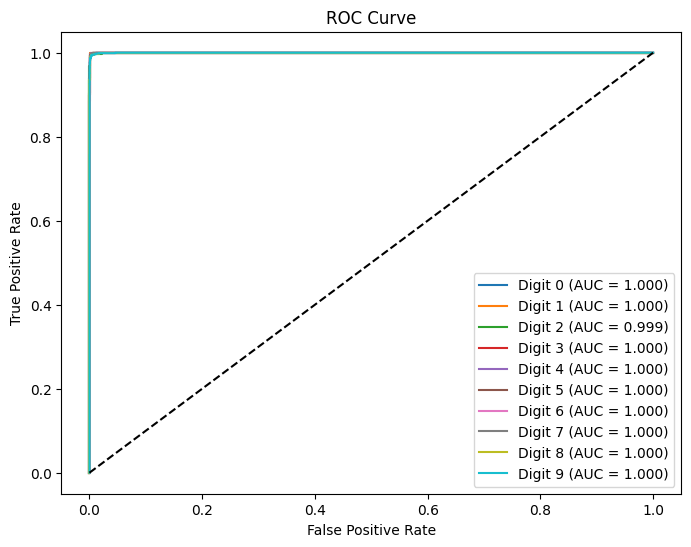

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Digit {i} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

CIFAR Dataset

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

In [ ]:
x_train, x_val, y_train_cat, y_val_cat, y_train, y_val = train_test_split(
    x_train, y_train_cat, y_train, test_size=0.2, random_state=42
)

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train_cat, epochs=15, validation_data=(x_val, y_val_cat), batch_size=64)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2804 - loss: 1.9234 - val_accuracy: 0.5116 - val_loss: 1.3234
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4992 - loss: 1.3881 - val_accuracy: 0.6123 - val_loss: 1.1049
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5897 - loss: 1.1677 - val_accuracy: 0.6535 - val_loss: 0.9712
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6376 - loss: 1.0387 - val_accuracy: 0.6836 - val_loss: 0.9169
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6757 - loss: 0.9391 - val_accuracy: 0.6972 - val_loss: 0.8521
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6954 - loss: 0.8693 - val_accuracy: 0.7168 - val_loss: 0.8173
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7220 - loss: 0.7961 - val_accuracy: 0.7263 - val_loss: 0.7950
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7416 - loss: 0.7446 - val_accuracy: 0.

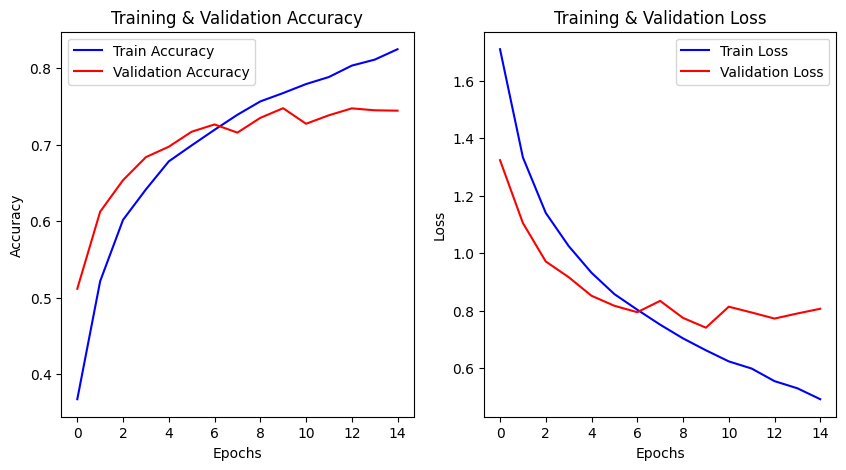

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat)
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7495 - loss: 0.8192
Test Accuracy: 0.7429


In [ ]:
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-Score: {report['weighted avg']['f1-score']:.4f}")

Precision: 0.7440
Recall: 0.7429
F1-Score: 0.7397


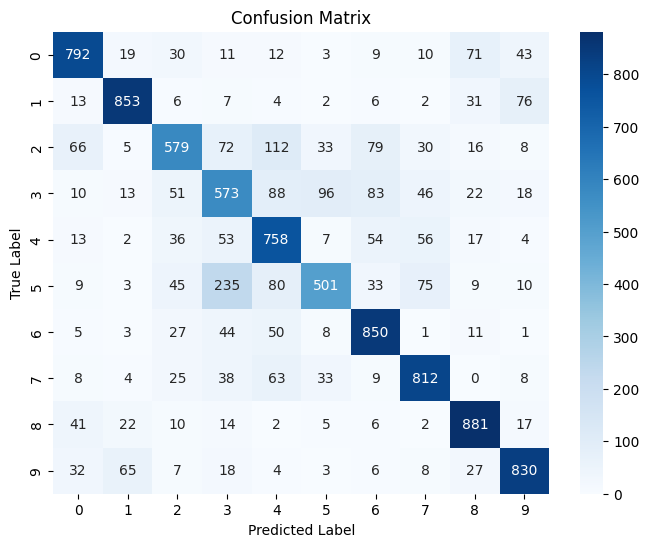

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

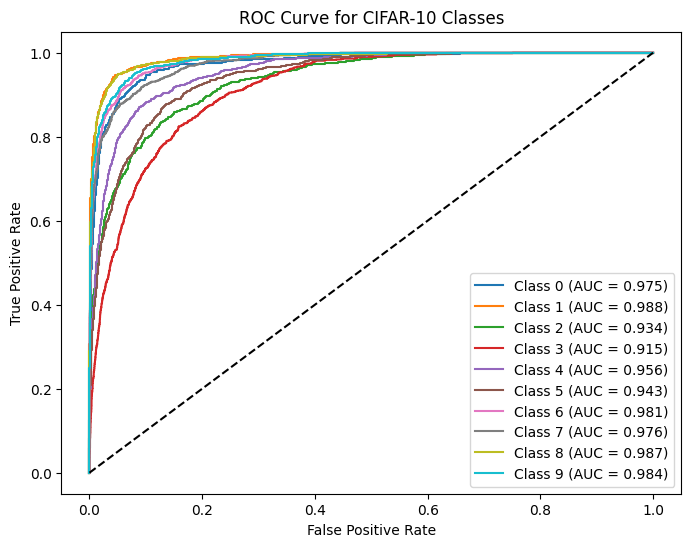

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CIFAR-10 Classes")
plt.legend()
plt.show()